In [4]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import math
import scipy.fft as fft
from functools import partial
from scipy import signal
%matplotlib notebook

In [37]:
sampling = 0.1

#plt.rcParams['figure.figsize'] = [11, 13]
#plt.rcParams['figure.dpi'] = 100
xRange = 5
x = np.arange(-xRange, xRange, sampling)

In [38]:
def FFT(data):
    return fft.fft(data, len(data))
def iFFT(data):
    return fft.ifft(data)

#get axis to plot FT on
def getFreqAxis(x):
    return np.fft.fftfreq(len(x), d=sampling)

def flipAtOrigin(data):
    return np.concatenate([data[len(data)//2:], data[:len(data)//2],])
        

def rect(w, x):
    return 1 if np.abs(x)<=w else 0

In [39]:
def rollingAverage (data, radius = 5.0):
    radius = int(radius)
    
    out = np.zeros(len(data))
    for i in range(len(data)):
        count = 0
        sum_val = 0
        for j in range(-radius, radius):
            count+=1
            sum_val += data[i+j] if 0 <= i+j < len(data)  else 0
        out[i] = sum_val/count
    return out

In [40]:
def lowPassFilterPerfect(w, x):
    return 1.0 if np.abs(x) < w else 0

In [41]:
def lowPass(w, x, values):
    #print(len(x))
    #print(len(values))
    freqAxis = np.fft.fftfreq(len(x), d=x[1]-x[0])

    data = np.vectorize(partial(lowPassFilterPerfect, w), otypes=[np.complex128])(freqAxis)
    fil = np.fft.ifft(data)
    fil = flipAtOrigin(fil)
    
    r_fil = rollingAverage(np.vectorize(partial(rect, 1.0))(x), 1.0)*fil
    
    filtered = np.convolve(r_fil, values, 'same')

    return filtered

In [42]:
#x - fft of original
#y - resampled fft
#fills y with zeros in the middle
def upsample(x, y):
    N = len(x)
    M = len(y)
    for i in range(len(y)):
        if 0<=i<=N/2:
            y[i] = x[i]
        if N/2 + M - N < i < M:
            y[i] = x[i-M+N]

#y - destination
#x - source
def downsample(x, y):
    N = len(x)
    M = len(y)
    ratio = math.ceil(N/M)
    for i in range(M):
        y[i] = x[i*ratio]
        

def resample(data, newLen):
    fftData = FFT(data)
    
    result = np.zeros(newLen, dtype = np.complex128)
    if newLen >= len(data):
        scaledFt = np.zeros(newLen, dtype = np.complex128)
        upsample(fftData, scaledFt)
        result = fft.ifft(scaledFt)*newLen/len(data)
    else:
        ratio = math.ceil(len(data)/newLen) 
        #upsample source so that we can downsample it by selecting every <ratio>'s element
        nearest = resample(data, newLen*ratio)
        #filter it to remove high frequency
        highCutoffFreq = 0.5/(2*xRange/newLen)
        #print(str(highCutoffFreq) + " " + str(2*xRange/newLen))
        nearest = lowPass(highCutoffFreq, np.arange(-xRange, xRange, 2*xRange/len(nearest)), nearest)
        #return nearest
        downsample(nearest, result)

    return result

In [43]:
def getFreqPlot(data, label, x):
    freqAxis = np.fft.fftfreq(len(x), d=x[1]-x[0])
    freqAxis = freqAxis[:len(freqAxis)//2]
    return {'data': np.abs(data[:len(data)//2]), 'label': label, 'x': freqAxis[:len(data)//2]}

In [67]:
anims = []

def animate_f(fig, x, data, i):
    fig.set_data(x[i%len(data)], data[i%len(data)])  # update the data.
    
    return fig,

In [69]:
def showPlotsAnim(plots):
    colors = ['#06d6a0', '#277da1', '#ee6c4d','#5a189a','#f3722c']
    plotCount = 0
    
    for i in range(len(plots)):
        if 'same' not in plots[i] or plots[i]['same'] == False:
            plotCount+=1
            
    fig, axs = plt.subplots(plotCount)
    pid = 0
    figs = []
    for i in range(len(plots)):
        if 'same' in plots[i] and plots[i]['same'] == True and pid > 0:
            pid -= 1            
        if 'x' not in plots[i]:
            fg, = axs[pid].plot(plots[i]['data'][0], label = plots[i]['label'], color = colors[i%len(colors)])
            figs.append(fg)
        else:
            fg, = axs[pid].plot(plots[i]['x'][0], plots[i]['data'][0], label = plots[i]['label'], color = colors[i%len(colors)])
            figs.append(fg)
        axs[pid].grid()
        axs[pid].legend(loc = 'upper right')
        
        pid+=1
        
    for i in range(len(figs)):
        anims.append(animation.FuncAnimation(
            fig, partial(animate_f, figs[i],plots[i]['x'], plots[i]['data']), interval=200, blit=True, save_count=50))
    
    plt.show()

In [70]:
def sampleRateConv(data, lower, upper):
    
    infoOrig = []
    infoOrigX = []

    infoScaled = []
    infoScaledX = []
    for i in range(lower, upper):
        fftData = FFT(data)
        scaled = resample(data, i)
        infoOrig.append(np.real(data))
        infoOrigX.append(x)
        
        infoScaled.append(np.real(scaled))
        infoScaledX.append(np.arange(-xRange, xRange, 2*xRange/len(scaled)))
    #showPlotsAnim([getFreqPlot(fftData, "original fft", np.arange(-xRange, xRange, 2*xRange/len(fftData))),
    #           getFreqPlot(FFT(scaled), "resampled fft", np.arange(-xRange, xRange, 2*xRange/len(scaled))),
    #           {'data': np.real(scaled), 'label': "resampled signal " + str(len(scaled)), 'x': np.arange(-xRange, xRange, 2*xRange/len(scaled))},
    #           {'data': np.real(data), 'label': "original signal " + str(len(data)), 'x': x}])
    showPlotsAnim([
               {'data': infoScaled, 'label': "resampled signal " + str(len(scaled)), 'x': infoScaledX},
               {'data': infoOrig, 'label': "original signal " + str(len(data)), 'x': infoOrigX}])

<IPython.core.display.Javascript object>


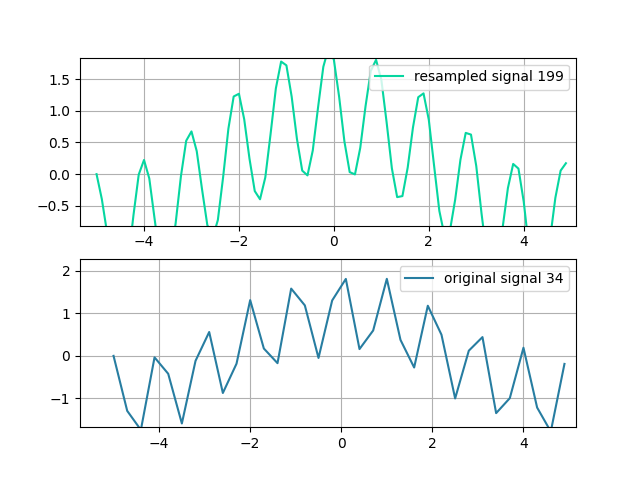

In [77]:
anims = []
sampling = 0.3
x = np.arange(-xRange, xRange, sampling)
sampleRateConv(np.vectorize(np.cos)(np.pi*2*x)+np.vectorize(np.cos)(np.pi*0.2*x), 20, 200)

In [87]:
anims = []
sampling = 0.1
x = np.arange(-xRange, xRange, sampling)
sampleRateConv(signal.square(2 * np.pi * 0.3 * x), 10, 99)

IndexError: index 123 is out of bounds for axis 0 with size 123